In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RealAmplitudes
import numpy as np
import torch
from torch.autograd import Variable

In [2]:
# esta función devolvera (M^-1)*P*D*(P^-1) si 'con_M' es True
# o devolverá P*D*(P^-1) si es False

def obtener_circuitos(parametros, n, reps, con_M = True):
    
    if len(parametros) != (2 * reps + 1) * (2*n - 1):
        raise Exception("longitud de parametros incorrecta")
        
    # reps = numero de veces que repetimos la estructura del ansantz
    # n = número de qubits con los que trabajaremos (sin ancillas)
    
    circ = QuantumCircuit(2*n - 1)
    
    M_1 = obtener_M_1(n)
    
    P, P_1 = obtener_Ps(parametros[:(2 * reps) * (2*n - 1)], n, reps)
    
    D = obtener_D(parametros[(2 * reps) * (2*n - 1):], n)
    
    if con_M:
        circ += M_1
    circ += P
    circ += D
    circ += P_1
    
    return circ

In [3]:
# M es el oráculo más la puerta de Grover
# Estas función devolverá la inversa de este circuito

def obtener_M_1(n):
    
    # número de qubits con los que vamos a trabajar (sin contar ancillas)
    
    M = QuantumCircuit(2 * n - 1)

    # Primera parte que marca un elemento, en este caso 11111111
    
    M.x(2*n - 2)
    M.h(2*n - 2)
    
    M.ccx(0,1,n)

    for i in range(2,n):
        M.ccx(i, n - 2 + i, n - 1 + i)
    
    
    
    for i in range(n-2,1, -1):
        M.ccx(i, n - 2 + i, n - 1 + i)
        
    M.ccx(0,1,n)
    
    M.h(2*n - 2)
    M.x(2*n - 2)
    # Segunda parte que aplica Grover
    
    M.h(range(n))
    M.x(range(n))

    M.ccx(0,1,n)
    for i in range(2,n-1):
        M.ccx(i, n - 2 + i, n - 1 + i)

    M.cz(2* n - 3,n - 1)

    for i in range(n - 2,1, -1):
        M.ccx(i, n - 2 + i, n - 1 + i)
    M.ccx(0,1,n)
    M.x(range(n))
    M.h(range(n))

    #hacemos la inversa
    M_1 = M.inverse()
    M_1
    return M_1



In [4]:
# Vamos a intentar aproximar P con un ansantz
# Utilizaremos el 2 de este paper: https://arxiv.org/pdf/1905.10876.pdf
# Además damos la opción de meter más de una capa (reps := numero de capas)

def obtener_Ps(parametros, n , reps):
    
    param_rep = int(len(parametros) / reps)
    P = QuantumCircuit(2*n - 1)
    for rep in range(reps):
        i = 0
        for j, p in enumerate(parametros[param_rep*i: param_rep*(i+1)]):
            if j % 2 == 0:
                P.rx(p, j//2)
            else:
                P.rz(p, (j-1)//2)
        i += 1
    
        for k in range(2*n - 2, 0, -1):
            P.cx(k, k-1)
            
    P_1 = P.inverse()
    
    return P, P_1


In [5]:
# Esta función devuelve D

def obtener_D(parametros, n):
    D = QuantumCircuit(2 * n - 1)
    
    for i in range(2 * n - 1):
        D.rz(parametros[i],i)
    
    return D



In [6]:
# el número de parametros sigue la siguiente formula
# len(parametros) := (2 * reps + 1) * (2*n - 1)

# por si queremos visualizar un ejemplo (3 qubits, 2 repeticiones de ansantz, 25 parametros que hacen falta)
# se vería más claro con barreras pero si las pongo luego da problemas


obtener_circuitos([0.1] * 25, 3, 2).draw()

┌───┐┌───┐             ┌───┐┌───┐               ┌─────────┐┌─────────┐»
q_0: ┤ H ├┤ X ├──■───────■──┤ X ├┤ H ├──■─────────■──┤ RX(0.1) ├┤ RZ(0.1) ├»
     ├───┤├───┤  │       │  ├───┤├───┤  │         │  ├─────────┤├─────────┤»
q_1: ┤ H ├┤ X ├──■───────■──┤ X ├┤ H ├──■─────────■──┤ RX(0.1) ├┤ RZ(0.1) ├»
     ├───┤├───┤  │       │  ├───┤├───┤  │         │  ├─────────┤├─────────┤»
q_2: ┤ H ├┤ X ├──┼───■───┼──┤ X ├┤ H ├──┼────■────┼──┤ RX(0.1) ├┤ RZ(0.1) ├»
     └───┘└───┘┌─┴─┐ │ ┌─┴─┐└───┘└───┘┌─┴─┐  │  ┌─┴─┐├─────────┤├─────────┤»
q_3: ──────────┤ X ├─■─┤ X ├──────────┤ X ├──■──┤ X ├┤ RX(0.1) ├┤ RZ(0.1) ├»
     ┌───┐┌───┐└───┘   └───┘          └───┘┌─┴─┐├───┤└──┬───┬──┘├─────────┤»
q_4: ┤ X ├┤ H ├────────────────────────────┤ X ├┤ H ├───┤ X ├───┤ RX(0.1) ├»
     └───┘└───┘                            └───┘└───┘   └───┘   └─────────┘»
«                                              ┌───┐   ┌─────────┐┌─────────┐»
«q_0: ─────────────────────────────────────────┤ X ├───┤ RX(0.1) ├┤ RZ(0.1) ├»
«                                   ┌───┐      └─┬─┘   ├─────────┤├─────────┤»
«q_1: ──────────────────────────────┤ X ├────────■─────┤ RX(0.1) ├┤ RZ(0.1) ├»
«                        ┌───┐      └─┬─┘   ┌─────────┐├─────────┤└──┬───┬──┘»
«q_2: ───────────────────┤ X ├────────■─────┤ RX(0.1) ├┤ RZ(0.1) ├───┤ X ├───»
«                ┌───┐   └─┬─┘   ┌─────────┐├─────────┤└──┬───┬──┘   └─┬─┘   »
«q_3: ───────────┤ X ├─────■─────┤ RX(0.1) ├┤ RZ(0.1) ├───┤ X ├────────■─────»
«     ┌─────────┐└─┬─┘┌─────────┐├─────────┤└─────────┘   └─┬─┘   ┌─────────┐»
«q_4: ┤ RZ(0.1) ├──■──┤ RX(0.1) ├┤ RZ(0.1) ├────────────────■─────┤ RZ(0.1) ├»
«     └─────────┘     └─────────┘└─────────┘                      └─────────┘»
«                   ┌───┐   ┌─────────┐┌───┐┌──────────┐┌──────────┐»
«q_0: ──────────────┤ X ├───┤ RZ(0.1) ├┤ X ├┤ RZ(-0.1) ├┤ RX(-0.1) ├»
«        ┌───┐      └─┬─┘   ├─────────┤└─┬─┘└──┬───┬───┘├──────────┤»
«q_1: ───┤ X ├────────■─────┤ RZ(0.1) ├──■─────┤ X ├────┤ RZ(-0.1) ├»
«        └─┬─┘   ┌─────────┐└─────────┘        └─┬─┘    └──┬───┬───┘»
«q_2: ─────■─────┤ RZ(0.1) ├─────────────────────■─────────┤ X ├────»
«     ┌─────────┐└─────────┘                               └─┬─┘    »
«q_3: ┤ RZ(0.1) ├────────────────────────────────────────────■──────»
«     └─────────┘                                                   »
«q_4: ──────────────────────────────────────────────────────────────»
«                                                                   »
«                    ┌───┐    ┌──────────┐┌──────────┐                        »
«q_0: ───────────────┤ X ├────┤ RZ(-0.1) ├┤ RX(-0.1) ├────────────────────────»
«     ┌──────────┐   └─┬─┘    └──┬───┬───┘├──────────┤┌──────────┐            »
«q_1: ┤ RX(-0.1) ├─────■─────────┤ X ├────┤ RZ(-0.1) ├┤ RX(-0.1) ├────────────»
«     ├──────────┤┌──────────┐   └─┬─┘    └──┬───┬───┘├──────────┤┌──────────┐»
«q_2: ┤ RZ(-0.1) ├┤ RX(-0.1) ├─────■─────────┤ X ├────┤ RZ(-0.1) ├┤ RX(-0.1) ├»
«     └──┬───┬───┘├──────────┤┌──────────┐   └─┬─┘    └──┬───┬───┘├──────────┤»
«q_3: ───┤ X ├────┤ RZ(-0.1) ├┤ RX(-0.1) ├─────■─────────┤ X ├────┤ RZ(-0.1) ├»
«        └─┬─┘    ├──────────┤├──────────┤               └─┬─┘    ├──────────┤»
«q_4: ─────■──────┤ RZ(-0.1) ├┤ RX(-0.1) ├─────────────────■──────┤ RZ(-0.1) ├»
«                 └──────────┘└──────────┘                        └──────────┘»
«                 
«q_0: ────────────
«                 
«q_1: ────────────
«                 
«q_2: ────────────
«     ┌──────────┐
«q_3: ┤ RX(-0.1) ├
«     ├──────────┤
«q_4: ┤ RX(-0.1) ├
«     └──────────┘

In [7]:
# Esta función se encarga de tomar unos parametros iniciales e ir optimizandolos con descenso de gradiente

def entrenar(n, reps, epochs):
    
    params = torch.tensor(np.random.rand((2 * reps + 1) * (2*n - 1)) * (2 * np.pi),  requires_grad=True)

    x = Variable(params, requires_grad=True)

    opt = torch.optim.SGD([x], lr=0.001)

    for epoch in range(epochs):
        if epoch % 50 == 0:
            print("epoch", epoch)
        #with torch.no_grad():
         #   for x_ in x:
          #      x_.clamp_(min= 0, max=1)

        loss = funcion_de_error(x, n, reps)
        opt.zero_grad()
        loss.backward()
        opt.step()
        solucion = list(x.detach().numpy())
    return plot_params(solucion, n, reps)

In [8]:
# Estamos calculando el error a través del hadamard-test

def funcion_de_error(parametros, n, reps):
    
    parametros = parametros.detach().numpy()
    
    
    qc = QuantumCircuit(2*n,1)
    qc.h(0)
    
    circ = obtener_circuitos(parametros, n, reps).to_gate()
    circ = circ.control(1)
    qc.append(circ, range(2*n))
    qc.h(0)
    qc.measure(0,0)

    shots = 10000
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=shots).result().get_counts()
    
    
    
    return torch.tensor(1 - result['0']/shots + result['1']/shots, requires_grad=True)

In [9]:
# Esta función ya calcula la salida final es decir:
# |0> - |H> - P * (D^k) * (P^-1) siendo k el número de iteraciones necesarias

def plot_params(parametros, n, reps):
    
    final = QuantumCircuit(2*n - 1,n)
    final.h(range(n))
    final += obtener_circuitos(parametros[:(2 * reps) * (2*n - 1)] + [l * int(2 ** (n/2)) for l in parametros[(2 * reps) * (2*n - 1):]], n,reps, con_M = False)
    final.measure(range(n), range(n))
    backend = Aer.get_backend("qasm_simulator")
    result = execute(final, backend, shots=10000).result().get_counts()
    return result

epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250


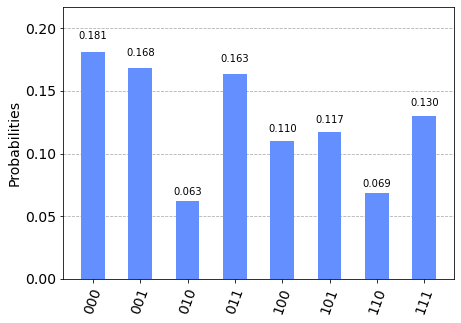

In [12]:
# primer parametro: número de qubits
# segundo parametro: número de repeticiones del ansantz
# tercer parametro: número de épocas para ejecutar el algoritmo

plot_histogram(entrenar(3,2,300))

# la salida esperada sería obtener una alta probabilidad en 111